In [119]:
import numpy as np
import torch

ignore_first_n_bars = 0
flattened_comparison = True

# load generations
generated_drums = torch.tensor(np.load(f'[Larger srcMasked 30prcnt] [bassGuiSynLead] no in vel_itzc90b6/120.pth/bern_True_prime_{ignore_first_n_bars}_bars_thres_0.50_gthresh_0.60_n_steps_per_gen_4/generated_drums.npy')[:, 2*16:, :9])
generated_grooves = torch.tensor(np.load(f'[Larger srcMasked 30prcnt] [bassGuiSynLead] no in vel_itzc90b6/120.pth/bern_True_prime_{ignore_first_n_bars}_bars_thres_0.50_gthresh_0.60_n_steps_per_gen_4/generated_grooves.npy')[:, 2*16:, :1])
gt_drums = torch.tensor(np.load(f'[Larger srcMasked 30prcnt] [bassGuiSynLead] no in vel_itzc90b6/120.pth/bern_True_prime_{ignore_first_n_bars}_bars_thres_0.50_gthresh_0.60_n_steps_per_gen_4/drum_hvos_gt.npy')[:, 2*16:, :9])
gt_grooves = torch.tensor(np.load(f'[Larger srcMasked 30prcnt] [bassGuiSynLead] no in vel_itzc90b6/120.pth/bern_True_prime_{ignore_first_n_bars}_bars_thres_0.50_gthresh_0.60_n_steps_per_gen_4/groove_hvos_gt.npy')[:, 2*16:, :1])

if flattened_comparison:
    generated_drums = generated_drums.sum(dim=2).clamp(0, 1).unsqueeze(-1)
    gt_drums = gt_drums.sum(dim=2).clamp(0, 1).unsqueeze(-1)
    


In [120]:
def jaccard(hvo_1, hvo_2):
    hvo_1 = hvo_1.reshape(hvo_1.shape[0], -1)
    hvo_2 = hvo_2.reshape(hvo_2.shape[0], -1)
    intersection = torch.sum(hvo_1 * hvo_2, dim=1)
    union = torch.sum(hvo_1 + hvo_2, dim=1)
    jac = intersection / (union - intersection)
    jac[torch.isnan(jac)] = 0
    return jac

def extract_segments(hvo_, n_bars_per_seg):
    n_bars = hvo_.shape[1] // 16
    n_segs = n_bars // n_bars_per_seg
    hvo_ = hvo_[:, :n_segs*n_bars_per_seg*16, :]
    hvo_ = hvo_.reshape(hvo_.shape[0], n_segs, n_bars_per_seg*16, hvo_.shape[2])
    return hvo_
    
def compute_intra_jaccards(hvo_, n_bars_per_seg):
    hvo_segments = extract_segments(hvo_, n_bars_per_seg)
    N = hvo_segments.shape[1]
    intra_jaccards = torch.zeros(hvo_segments.shape[0], N*(N-1)//2)
    count = 0
    for i in range(0, N-1):
        for j in range(i+1, N):
            intra_jaccards[:, count] = jaccard(hvo_segments[:, i, :, :], hvo_segments[:, j, :, :])
            count += 1
    return intra_jaccards


def compute_inter_jaccards(hvo_1, hvo_2, n_bars_per_seg):
    hvo_1_segments = extract_segments(hvo_1, n_bars_per_seg)
    hvo_2_segments = extract_segments(hvo_2, n_bars_per_seg)
    N = hvo_1_segments.shape[1]
    inter_jaccards = torch.zeros(hvo_1_segments.shape[0], N)
    
    for i in range(N):
        inter_jaccards[:, i] = jaccard(hvo_1_segments[:, i, :, :], hvo_2_segments[:, i, :, :])
        
    return inter_jaccards

In [121]:
# INTRA JACCARDS

intra_generation_jaccards = compute_intra_jaccards(generated_drums, 1)
intra_gt_jaccards = compute_intra_jaccards(gt_drums, 1)

# get box_plot data for each example
intra_gen_average = torch.mean(intra_generation_jaccards, dim=1)
intra_gt_average = torch.mean(intra_gt_jaccards, dim=1)




In [122]:
# INTER JACCARDS
inter_jaccards = compute_inter_jaccards(generated_drums, gt_drums, 1).mean(dim=1)



In [123]:
# pair inter (gt, gen) with intra (gt) 

sorted_inter_jaccards, indices = torch.sort(inter_jaccards)
sorted_intra_gt = intra_gt_average[indices]

In [124]:
fi = -100
sorted_inter_jaccards[fi], sorted_intra_gt[fi], indices[fi]
print(f'Inter: {sorted_inter_jaccards[fi]:0.2f}, IraGt: {sorted_intra_gt[fi]:0.2f}, IraGen: {intra_gen_average[indices[fi]]:0.2f}, Index: {indices[fi]}')

Inter: 0.93, IraGt: 0.91, IraGen: 0.96, Index: 387


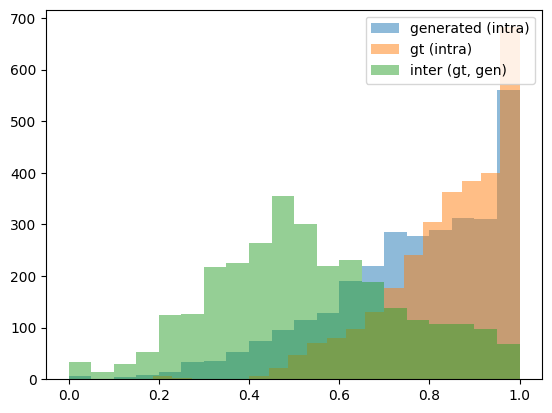

In [125]:
# show histograms
import matplotlib.pyplot as plt
plt.hist(intra_gen_average, bins=20, alpha=0.5, label='generated (intra)')
plt.hist(intra_gt_average, bins=20, alpha=0.5, label='gt (intra)')
plt.hist(inter_jaccards.flatten(), bins=20, alpha=0.5, label='inter (gt, gen)')

plt.legend(loc='upper right')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


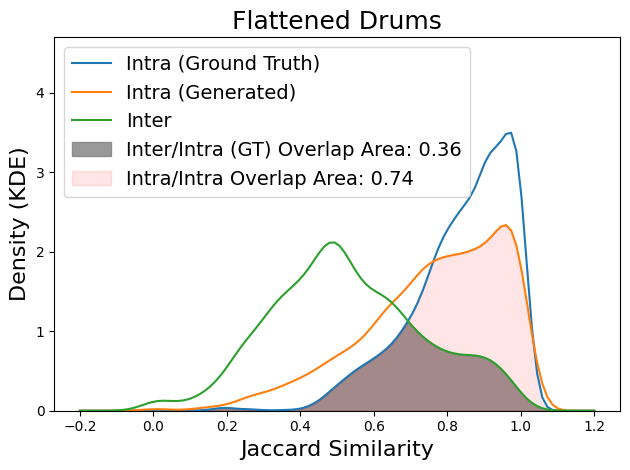

In [126]:

# Calculate the kdes, using scott's rule
from scipy.stats import gaussian_kde
from scipy.special import rel_entr

kde_gen = gaussian_kde(intra_gen_average.numpy(), bw_method='scott')
kde_gt = gaussian_kde(intra_gt_average.numpy(), bw_method='scott')
kde_inter = gaussian_kde(inter_jaccards.flatten().numpy(), bw_method='scott')

# plot
x = np.linspace(-.2, 1.2, 100)
plt.ylim(0, 4.7)
plt.plot(x, kde_gt(x))
plt.plot(x, kde_gen(x))
plt.plot(x, kde_inter(x))
plt.legend(loc='upper right')

from scipy.integrate import quad

# Define a range that covers the significant density areas of both KDEs
x_min = min(kde_gt.dataset.min(), kde_inter.dataset.min())
x_max = max(kde_gt.dataset.max(), kde_inter.dataset.max())
x_grid = np.linspace(x_min, x_max, 1000)
# Evaluate both KDEs on the grid
p1 = kde_gt.evaluate(x_grid)
q1 = kde_inter.evaluate(x_grid)
# Normalize the evaluated KDEs to ensure they sum to 1
p1 /= np.sum(p1)
q1 /= np.sum(q1)
kl_div1= np.sum(rel_entr(p1, q1))

# Define a function to calculate the minimum of the two KDEs at a given point
def min_kde1(x):
    return min(kde_gt(x), kde_inter(x))

# Integrate the minimum of the two KDEs over the range
overlap_area1, _ = quad(min_kde1, x_min, x_max)

# highlight the Overlap Area and put Overlap Area in the legend
area_under1 = np.array([min(kde_gt(x), kde_inter(x)).item() for x in x])

# kl divergence

# fill shaded area
plt.fill_between(x, area_under1, color='gray', alpha=0.8)

def min_kde2(x):
    return min(kde_gen(x), kde_gt(x))

# Integrate the minimum of the two KDEs over the range
overlap_area2, _ = quad(min_kde2, x_min, x_max)

# highlight the Overlap Area and put Overlap Area in the legend
area_under2 = np.array([min(kde_gen(x), kde_gt(x)).item() for x in x])

# fill shaded area
plt.fill_between(x, area_under2, color='red', alpha=0.1)

# add legend


plt.legend(['Intra (Ground Truth)', 'Intra (Generated)', 'Inter', f'Inter/Intra (GT) Overlap Area: {overlap_area1:.2f}', f'Intra/Intra Overlap Area: {overlap_area2:.2f}'], fontsize=14)

plt.xlabel('Jaccard Similarity', fontsize=16)
plt.ylabel('Density (KDE)', fontsize=16)

if not flattened_comparison:
    plt.title('Full Drums', fontsize=18)
else:
    plt.title('Flattened Drums', fontsize=18)
plt.tight_layout()

    
plt.savefig(f'inter_intra_overlap_{ignore_first_n_bars}bar_primed_flat_{flattened_comparison}.png', dpi=300)

plt.show()


In [127]:
# get 